In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Excel dosyasının tam yolu
file_path = '/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx'

# Dosyayı oku
df = pd.read_excel(file_path)


Mounted at /content/drive


In [ ]:
df['price_class'] = pd.qcut(df['price'], 3, labels=[0, 1, 2])
df['price_class'] = df['price_class'].astype(int)

In [ ]:
# ======================== FEATURE ENGINEERING ========================

# 1. Yeni oran: Metrekare başına fiyat
df['fiyat_m2'] = df['price'] / df['netSqm']

# 2. Yaş kategorisi (0: yeni, 1: orta, 2: eski)
df['yas_kategori'] = pd.cut(df['age'], bins=[-1, 5, 15, df['age'].max()], labels=["yeni", "orta", "eski"])

# 3. Oda + salon sayısı toplamı
df['toplam_oda'] = df['room'] + df['livingRoom']

# 4. Dairenin konumu (giriş, orta kat, çatı vb.)
def kat_kategori(row):
    try:
        kat = int(row['daire_kati'])
        toplam_kat = int(row['bina_kat_sayisi'])
        if kat == 1:
            return "giriş"
        elif kat == toplam_kat:
            return "çatı"
        elif kat > 1 and kat < toplam_kat:
            return "orta"
        else:
            return "bilinmeyen"
    except:
        return "bilinmeyen"

df['kat_konumu'] = df.apply(kat_kategori, axis=1)

# 5. Cephesi sayısı (kaç cepheye bakıyor)
df['cephe_sayisi'] = df[['kuzey', 'guney', 'dogu', 'bati']].sum(axis=1)

# 6. Lüks özellik sayısı (goldeniz, bahceli, havuzlu toplamı)
df['luksluk'] = df[['goldeniz', 'bahceli', 'havuzlu']].sum(axis=1)

# ======================== FEATURE ENGINEERING BİTTİ ========================


Price_class ile olan korelasyonlar:

price_class        1.000000
room               0.632992
toplam_oda         0.616601
bathRoom           0.534321
price              0.486144
fiyat_m2           0.419705
netSqm             0.414170
grossSqm           0.226037
livingRoom         0.198436
bahceli            0.155370
luksluk            0.114007
havuzlu            0.071826
cephe_sayisi       0.059436
kuzey              0.053332
dogu               0.040335
bati               0.036907
guney              0.023558
goldeniz          -0.002807
furnished         -0.071353
age               -0.075019
bina_kat_sayisi   -0.282896
daire_kati        -0.429416
Name: price_class, dtype: float64


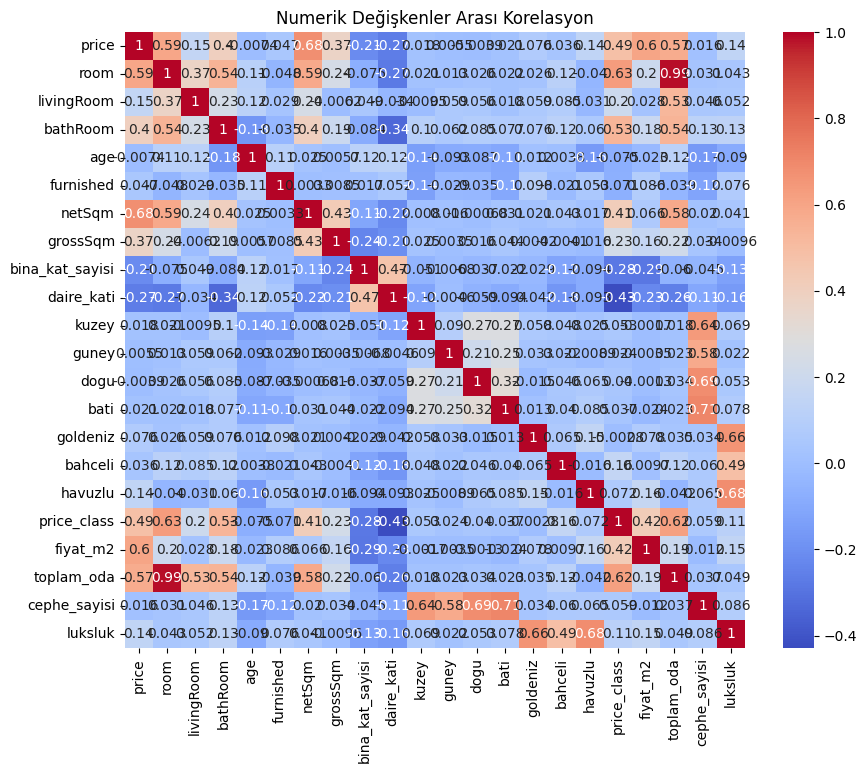

In [ ]:
# ======================== KORELASYON ANALİZİ ========================

import seaborn as sns
import matplotlib.pyplot as plt

# price_class ile olan korelasyonları hesapla (sadece sayısal veriler)
korelasyonlar = df.corr(numeric_only=True)['price_class'].sort_values(ascending=False)

print("Price_class ile olan korelasyonlar:\n")
print(korelasyonlar)

# İsteğe bağlı: Korelasyonları ısı haritasıyla göster
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Numerik Değişkenler Arası Korelasyon')
plt.show()

# ======================== KORELASYON ANALİZİ BİTTİ ========================


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Doğru dosya yolu
file_path = '/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx'

# Excel dosyasını oku
df = pd.read_excel(file_path)

# price sütununu üç sınıfa ayıralım ve yeni bir sütun oluşturalım
df['price_class'] = pd.qcut(df['price'], q=3, labels=[0, 1, 2])

# Sınıfların hangi fiyat aralıklarına karşılık geldiğini ve her sınıfta kaç örnek olduğunu görelim
price_bins = pd.qcut(df['price'], q=3)
class_distribution = price_bins.value_counts().sort_index()

# İlk birkaç satırı görelim, price ve price_class dahil
df_preview = df[['price', 'price_class']].head()

class_distribution, df_preview


(price
 (18999.999, 2350000.0]      732
 (2350000.0, 4350000.0]      725
 (4350000.0, 138000000.0]    722
 Name: count, dtype: int64,
       price price_class
 0   2500000           1
 1   1500000           0
 2  19500000           2
 3   3350000           1
 4   3700000           1)

In [ ]:
# Kategorik sütunları otomatik olarak belirleyelim
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# price_class dahil değilse, kontrol edelim
if 'price_class' in categorical_cols:
    categorical_cols.remove('price_class')

print("Kategorik sütunlar:", categorical_cols)


Kategorik sütunlar: ['district', 'county', 'residence', 'heating', 'fuel', 'build', 'buildState', 'furnished', 'subCategory']


In [ ]:
# LabelEncoder nesnesini oluştur
le = LabelEncoder()

# Her bir kategorik sütunu encode et
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [ ]:
# Özellikler ve hedef değişkeni ayıralım
X = df.drop(columns=['price', 'price_class'])  # 'price' ve 'price_class' modelde kullanılmamalı
y = df['price_class']  # Hedef sütunumuz

# Eğitim ve test verisine ayıralım (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gaussian Naive Bayes modelini oluştur
gnb = GaussianNB()

# Modeli eğitim verisiyle eğit
gnb.fit(X_train, y_train)

# Test verisiyle tahmin yap
y_pred = gnb.predict(X_test)

# Doğruluk oranını hesapla
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk Oranı:", accuracy)

 # Hata oranını hesapla ve yazdır
error_rate = 1 - accuracy_score(y_test, y_pred)
print("Hata Oranı:", error_rate)

# Sınıflandırma raporunu yazdır
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Karışıklık matrisini yazdır
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Doğruluk Oranı: 0.6674311926605505
Hata Oranı: 0.3325688073394495

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       147
           1       0.53      0.56      0.54       143
           2       0.79      0.60      0.68       146

    accuracy                           0.67       436
   macro avg       0.68      0.67      0.66       436
weighted avg       0.68      0.67      0.67       436


Confusion Matrix:
[[124  16   7]
 [ 47  80  16]
 [  3  56  87]]


In [ ]:
#Fiyat Sınıflandırması: GaussianNB vs Random Forest

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Dosya yolunu yeniden tanımla (bu Colab için değil, yerel yükleme sonrası kullanıma uygun)
file_path = '/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx'

# Excel dosyasını oku
df = pd.read_excel(file_path)

# price sütununu üç sınıfa ayır (düşük, orta, yüksek gibi)
df['price_class'] = pd.qcut(df['price'], q=3, labels=[0, 1, 2])

# Kategorik sütunları otomatik olarak belirle (object + bool türleri)
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Eğer price_class yanlışlıkla listeye eklendiyse çıkar
if 'price_class' in categorical_cols:
    categorical_cols.remove('price_class')

# Her bir kategorik sütunu kendi LabelEncoder nesnesi ile encode et
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Özellikler ve hedef değişkeni ayır
X = df.drop(columns=['price', 'price_class'])
y = df['price_class']

# Eğitim ve test verisi olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# İki model eğit: GaussianNB ve RandomForest (karşılaştırma için)
models = {
    "Naive Bayes (GaussianNB)": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score (macro avg)": f1_score(y_test, y_pred, average='macro'),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }
results

{'Naive Bayes (GaussianNB)': {'Accuracy': 0.6674311926605505,
  'F1 Score (macro avg)': 0.6648820170459545,
  'Classification Report': {'0': {'precision': 0.7126436781609196,
    'recall': 0.8435374149659864,
    'f1-score': 0.7725856697819314,
    'support': 147.0},
   '1': {'precision': 0.5263157894736842,
    'recall': 0.5594405594405595,
    'f1-score': 0.5423728813559322,
    'support': 143.0},
   '2': {'precision': 0.7909090909090909,
    'recall': 0.5958904109589042,
    'f1-score': 0.6796875,
    'support': 146.0},
   'accuracy': 0.6674311926605505,
   'macro avg': {'precision': 0.6766228528478982,
    'recall': 0.6662894617884834,
    'f1-score': 0.6648820170459545,
    'support': 436.0},
   'weighted avg': {'precision': 0.6777396923328424,
    'recall': 0.6674311926605505,
    'f1-score': 0.6659719965409225,
    'support': 436.0}},
  'Confusion Matrix': array([[124,  16,   7],
         [ 47,  80,  16],
         [  3,  56,  87]])},
 'Random Forest': {'Accuracy': 0.782110091743

# Model        Doğruluk (Accuracy)    F1 Skoru (Macro Avg.)
#   Gaussian Naive Bayes     0.667                 0.665
#       Random Forest        0.782                 0.784

In [ ]:
# Modelin Türünü Değiştirdim: CategoricalNB (Eğer verilerin çoğu kategorikse)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report, accuracy_score

# Dosyayı oku
file_path = '/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx'
df = pd.read_excel(file_path)

# Fiyatı kategorik hale getir
df['price_category'] = pd.qcut(df['price'], q=3, labels=['low', 'medium', 'high'])

# Kategorik öznitelikler
categorical_features = [
    'district', 'county', 'residence', 'heating', 'fuel',
    'build', 'buildState', 'furnished', 'subCategory'
]

X = df[categorical_features]
y = df['price_category']

# Sayısal kodlama
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Eğitim/test ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Model eğitimi
model = CategoricalNB()
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)

# Performans metrikleri
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
report = classification_report(y_test, y_pred)

# Sonuçları yazdır
print(" Naive Bayes CategoricalNB Model Performansı")
print("----------------------------------------------")
print("Accuracy       :", accuracy)
print("Error Rate     :", error_rate)
print("\nClassification Report:\n", report)


 Naive Bayes CategoricalNB Model Performansı
----------------------------------------------
Accuracy       : 0.6743119266055045
Error Rate     : 0.32568807339449546

Classification Report:
               precision    recall  f1-score   support

        high       0.76      0.78      0.77       146
         low       0.68      0.86      0.76       147
      medium       0.53      0.37      0.44       143

    accuracy                           0.67       436
   macro avg       0.66      0.67      0.66       436
weighted avg       0.66      0.67      0.66       436



In [ ]:
#(KBinsDiscretizer + CategoricalNB + OrdinalEncoder) yöntemini uyguladık.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Veriyi oku
file_path = '/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx'
df = pd.read_excel(file_path)

# 2. price sütununu 3 sınıfa böl (hedef değişkeni oluştur)
df['price_class'] = pd.qcut(df['price'], q=3, labels=[0, 1, 2])

# 3. Kategorik ve sayısal sütunları belirle
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 'price' ve 'price_class' sütunlarını sayısal sütunlardan çıkar
for col in ['price', 'price_class']:
    if col in numerical_cols:
        numerical_cols.remove(col)

print("Numerical columns to discretize:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 4. Sayısal verileri kategorik hale getir (5 bin ile discretize)
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df[numerical_cols] = kbd.fit_transform(df[numerical_cols])

# 5. Kategorik verileri OrdinalEncoder ile encode et
oe = OrdinalEncoder()
df[categorical_cols] = oe.fit_transform(df[categorical_cols])

# 6. Özellik ve hedef değişkenleri ayır
X = df.drop(columns=['price', 'price_class'])
y = df['price_class']

# 7. Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Categorical Naive Bayes modeli oluştur ve eğit
cnb = CategoricalNB()
cnb.fit(X_train, y_train)

# 9. Tahmin yap
y_pred = cnb.predict(X_test)

# 10. Performans ölç
accuracy = accuracy_score(y_test, y_pred)
print("Doğruluk Oranı:", accuracy)

error_rate = 1 - accuracy
print("Hata Oranı    :", error_rate)

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Numerical columns to discretize: ['room', 'livingRoom', 'bathRoom', 'age', 'netSqm', 'grossSqm', 'bina_kat_sayisi', 'daire_kati', 'kuzey', 'guney', 'dogu', 'bati', 'goldeniz', 'bahceli', 'havuzlu']
Categorical columns: ['district', 'county', 'residence', 'heating', 'fuel', 'build', 'buildState', 'furnished', 'subCategory']
Doğruluk Oranı: 0.7293577981651376
Hata Oranı    : 0.27064220183486243

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       147
           1       0.61      0.52      0.57       143
           2       0.80      0.81      0.80       146

    accuracy                           0.73       436
   macro avg       0.72      0.73      0.72       436
weighted avg       0.72      0.73      0.72       436


Confusion Matrix:
[[125  22   0]
 [ 38  75  30]
 [  3  25 118]]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306

In [ ]:
#Log-Ölçekli Sınıflarla Naive Bayes Modeli

In [ ]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Veri setini oku
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx')

# 2. Fiyatı log(ln) ölçeğine çevir
df['log_price'] = np.log(df['price'])

# 3. Fiyatı 5 sınıfa böl (0: ucuz, 4: pahalı)
df['price_class'] = pd.qcut(df['log_price'], q=5, labels=False)

# 4. Kategorik değişkenleri sayısala çevir
kategorik_kolonlar = ['district', 'county', 'residence', 'heating', 'fuel']

for col in kategorik_kolonlar:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 5. Özellikler (X) ve hedef (y) belirle
X = df[['district', 'county', 'residence', 'room', 'livingRoom', 'bathRoom',
         'age', 'heating', 'fuel', 'netSqm', 'grossSqm', 'bina_kat_sayisi',
         'daire_kati', 'kuzey', 'guney', 'dogu', 'bati',
         'goldeniz', 'bahceli', 'havuzlu']]

y = df['price_class']

# 6. Eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Naive Bayes modeli kur ve eğit
model = GaussianNB()
model.fit(X_train, y_train)

# 8. Test verisinde tahmin yap
y_pred = model.predict(X_test)

# 9. Sonuçları göster
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk Oranı: {accuracy:.4f}")

error_rate = 1 - accuracy
print(f"Hata Oranı    : {error_rate:.4f}")


Confusion Matrix:
 [[62 13  7  2  4]
 [20 47 14  0  0]
 [ 4 31 40 13  3]
 [ 2  3 41 46  2]
 [ 3  2 10 37 30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        88
           1       0.49      0.58      0.53        81
           2       0.36      0.44      0.39        91
           3       0.47      0.49      0.48        94
           4       0.77      0.37      0.50        82

    accuracy                           0.52       436
   macro avg       0.55      0.52      0.52       436
weighted avg       0.55      0.52      0.52       436

Doğruluk Oranı: 0.5161
Hata Oranı    : 0.4839


In [ ]:
#Naive Bayes ve Decision Tree Karşılaştırması

In [ ]:
# 1. Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Veriyi oku
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx')

# 3. Sayısal sütunları temizle (0 ve altı değerleri medyanla değiştir)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_cols:
    df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)
    df[col].fillna(df[col].median(), inplace=True)

# 4. Fiyatı logaritmik skala ile dönüştür ve sınıflandır
df['price_log'] = np.log1p(df['price'])
df['price_class'] = pd.qcut(df['price_log'], q=3, labels=[0, 1, 2])

# 5. Kategorik sütunları belirle ve encode et
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
oe = OrdinalEncoder()
df[categorical_cols] = oe.fit_transform(df[categorical_cols].astype(str))

# 6. Özellikler ve hedef değişkeni ayır
X = df.drop(columns=['price', 'price_log', 'price_class'])
y = df['price_class']

# 7. Veri setini stratified böl
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Naive Bayes için hyperparametre denemeleri (n_bins & alpha)

results = []

for n_bins in [3, 5, 7]:
    numerical_cols_nb = X_train_base.select_dtypes(include=['int64', 'float64']).columns.tolist()
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    X_train = X_train_base.copy()
    X_test = X_test_base.copy()
    X_train[numerical_cols_nb] = kbd.fit_transform(X_train[numerical_cols_nb])
    X_test[numerical_cols_nb] = kbd.transform(X_test[numerical_cols_nb])

    for alpha in [0.01, 0.1, 0.5, 1.0, 2.0]:
        cnb = CategoricalNB(alpha=alpha)
        cnb.fit(X_train, y_train)
        y_pred = cnb.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        # Detaylı çıktıları kaldırdım
        results.append(('NaiveBayes', n_bins, alpha, acc))

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_base, y_train)
y_pred_dt = dt.predict(X_test_base)
acc_dt = accuracy_score(y_test, y_pred_dt)
results.append(('DecisionTree', '-', '-', acc_dt))

# Sonuçları sadece tablo olarak göster
import pandas as pd
results_df = pd.DataFrame(results, columns=['Model', 'n_bins', 'alpha', 'Accuracy'])
print("\nTüm Sonuçlar:\n", results_df.sort_values(by='Accuracy', ascending=False))


<ipython-input-20-fcff6d398a5e>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Co


Tüm Sonuçlar:
            Model n_bins alpha  Accuracy
0     NaiveBayes      3  0.01  0.738532
1     NaiveBayes      3   0.1  0.738532
2     NaiveBayes      3   0.5  0.738532
3     NaiveBayes      3   1.0  0.736239
4     NaiveBayes      3   2.0  0.736239
5     NaiveBayes      5  0.01  0.722477
6     NaiveBayes      5   0.1  0.722477
7     NaiveBayes      5   0.5  0.722477
8     NaiveBayes      5   1.0  0.722477
9     NaiveBayes      5   2.0  0.722477
10    NaiveBayes      7  0.01  0.713303
11    NaiveBayes      7   0.1  0.713303
14    NaiveBayes      7   2.0  0.713303
12    NaiveBayes      7   0.5  0.711009
13    NaiveBayes      7   1.0  0.711009
15  DecisionTree      -     -  0.711009


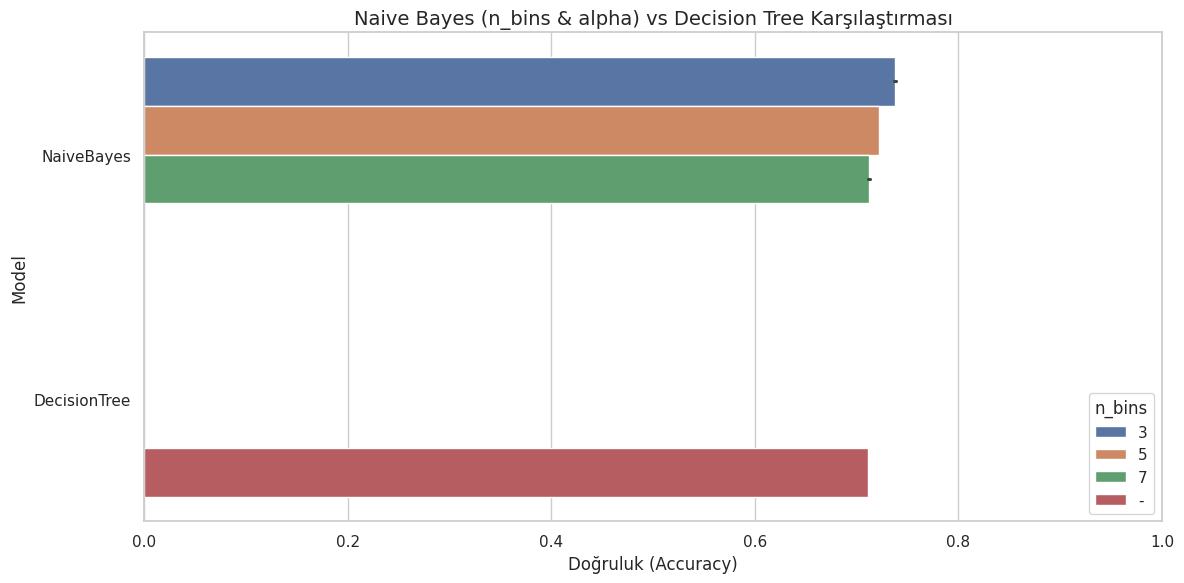

In [ ]:
#Naive Bayes ve Decision Tree Modellerinin Doğruluk (Accuracy) Karşılaştırması
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik için seaborn ayarları
sns.set(style="whitegrid")

# Model performanslarını görselleştir
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Accuracy', y='Model', hue='n_bins', dodge=True)

plt.title('Naive Bayes (n_bins & alpha) vs Decision Tree Karşılaştırması', fontsize=14)
plt.xlabel('Doğruluk (Accuracy)')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.legend(title='n_bins', loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
# Bu noktada en başarılı modelin hangi sınıfları doğru tahmin ettiğini daha derinlemesine incelemek için:
# Confusion matrix

# Naive Bayes Modeli ile Fiyat Sınıflandırması ve Confusion Matrix Analizi

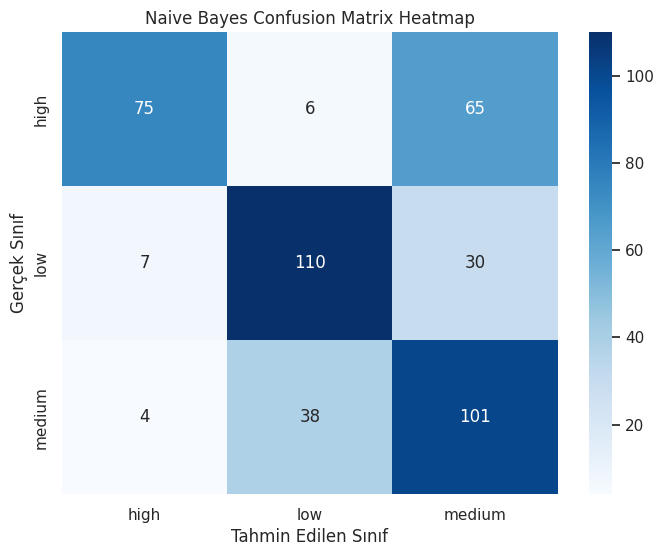

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# 1. Veri setini oku
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx')

# 2. Fiyat sütunu adı (burada 'price' olduğunu varsayıyorum)
price_col = 'price'

# 3. price_class oluştur (3 sınıf)
df['price_class'] = pd.qcut(df[price_col], q=3, labels=['low', 'medium', 'high'])

# 4. Sayısal sütunları seç (price_class ve price çıkar)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in [price_col, 'price_class']]

# 5. Özellik ve hedef değişkenleri belirle
X = df[numerical_features]
y = df['price_class']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. GaussianNB modelini eğit
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 8. Test seti üzerinde tahmin yap
y_pred = gnb.predict(X_test)

# 9. Confusion matrix oluştur
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)

# 10. Heatmap çizimi
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gnb.classes_, yticklabels=gnb.classes_)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Naive Bayes Confusion Matrix Heatmap')
plt.show()


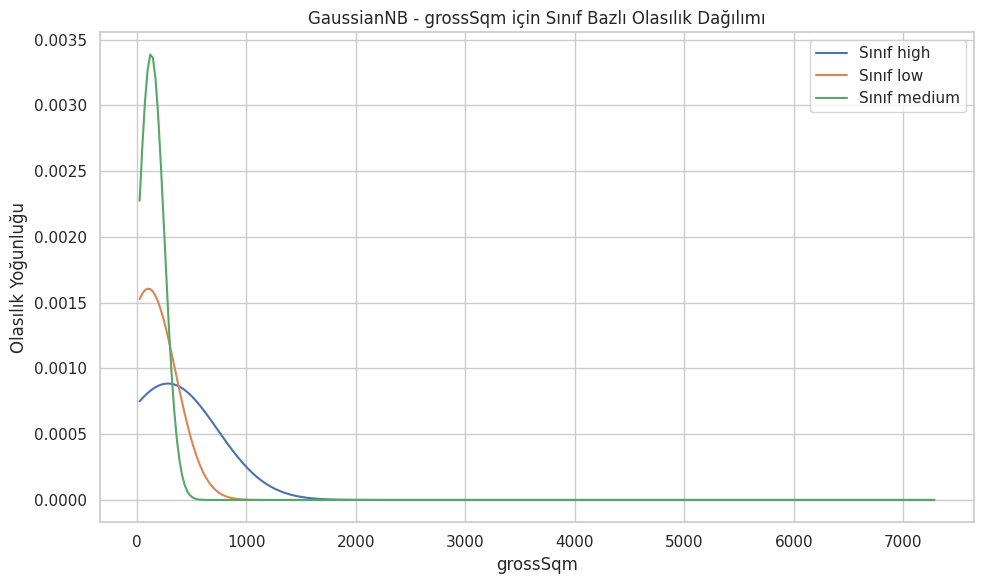

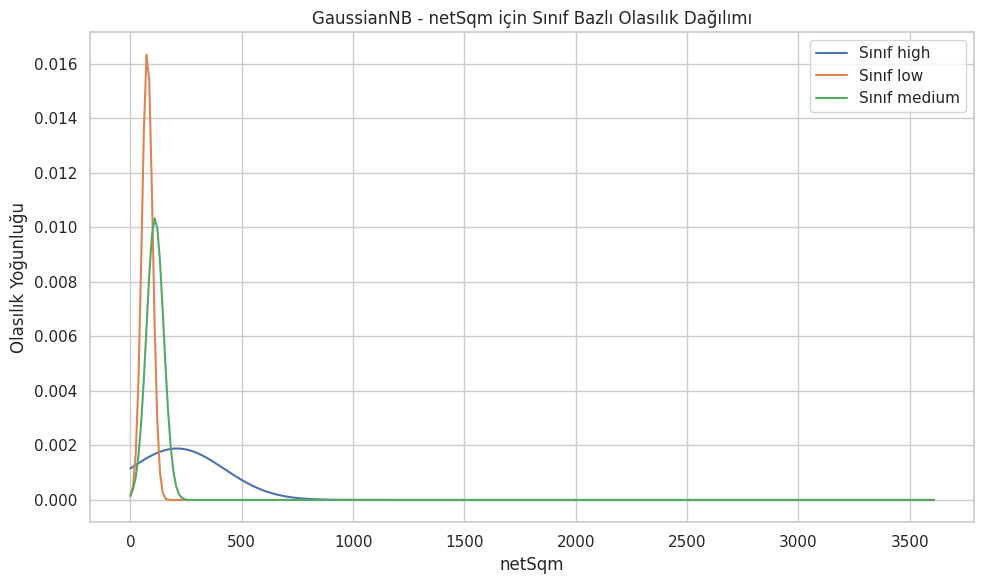

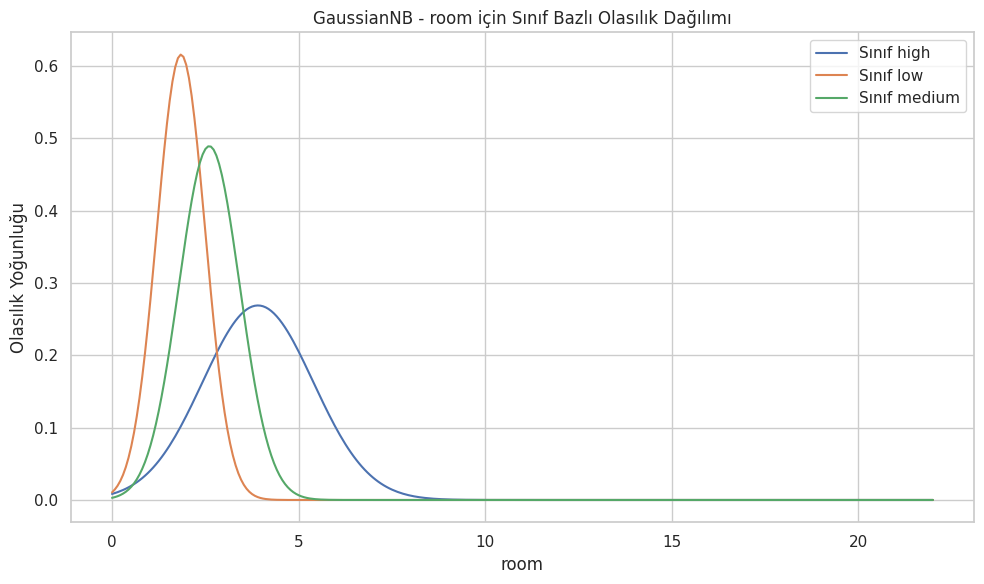

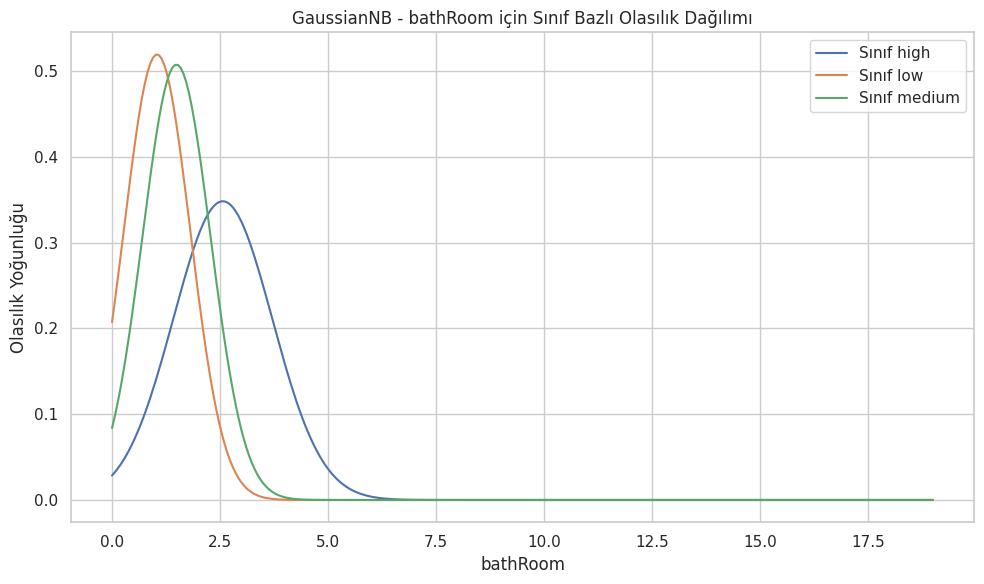

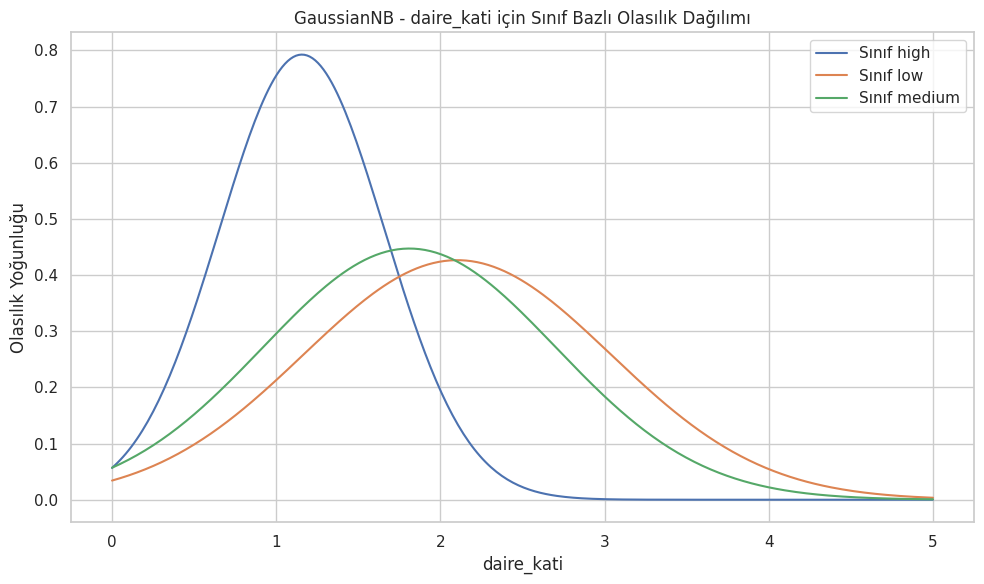

In [ ]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# 1. Veri setini oku
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx')

# 2. price_class oluştur (3 sınıf)
df['price_class'] = pd.qcut(df['price'], q=3, labels=['low', 'medium', 'high'])

# 3. Sayısal sütunları seç (price ve price_class hariç)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['price', 'price_class']]

# 4. Özellikler ve hedef değişken
X = df[numerical_features]
y = df['price_class']

# 5. Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. GaussianNB modeli eğit
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 7. En bilgilendirici 5 özellik (mutual information ile)
info_scores = mutual_info_classif(X_train, y_train, discrete_features=False)
info_df = pd.DataFrame({'feature': numerical_features, 'score': info_scores})
top_features = info_df.sort_values(by='score', ascending=False).head(5)['feature'].tolist()

# 8. Gaussian dağılım çizimi (sadece en iyi 5 özellik için)
classes = gnb.classes_

for i, feature in enumerate(top_features):
    plt.figure(figsize=(10, 6))
    x_min, x_max = X_train[feature].min(), X_train[feature].max()
    x_vals = np.linspace(x_min, x_max, 300)

    feat_index = numerical_features.index(feature)

    for idx, cls in enumerate(classes):
        mean = gnb.theta_[idx][feat_index]
        var = gnb.var_[idx][feat_index]
        std = np.sqrt(var)
        pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - mean) / std) ** 2)
        plt.plot(x_vals, pdf, label=f'Sınıf {cls}')

    plt.title(f'GaussianNB - {feature} için Sınıf Bazlı Olasılık Dağılımı')
    plt.xlabel(feature)
    plt.ylabel('Olasılık Yoğunluğu')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

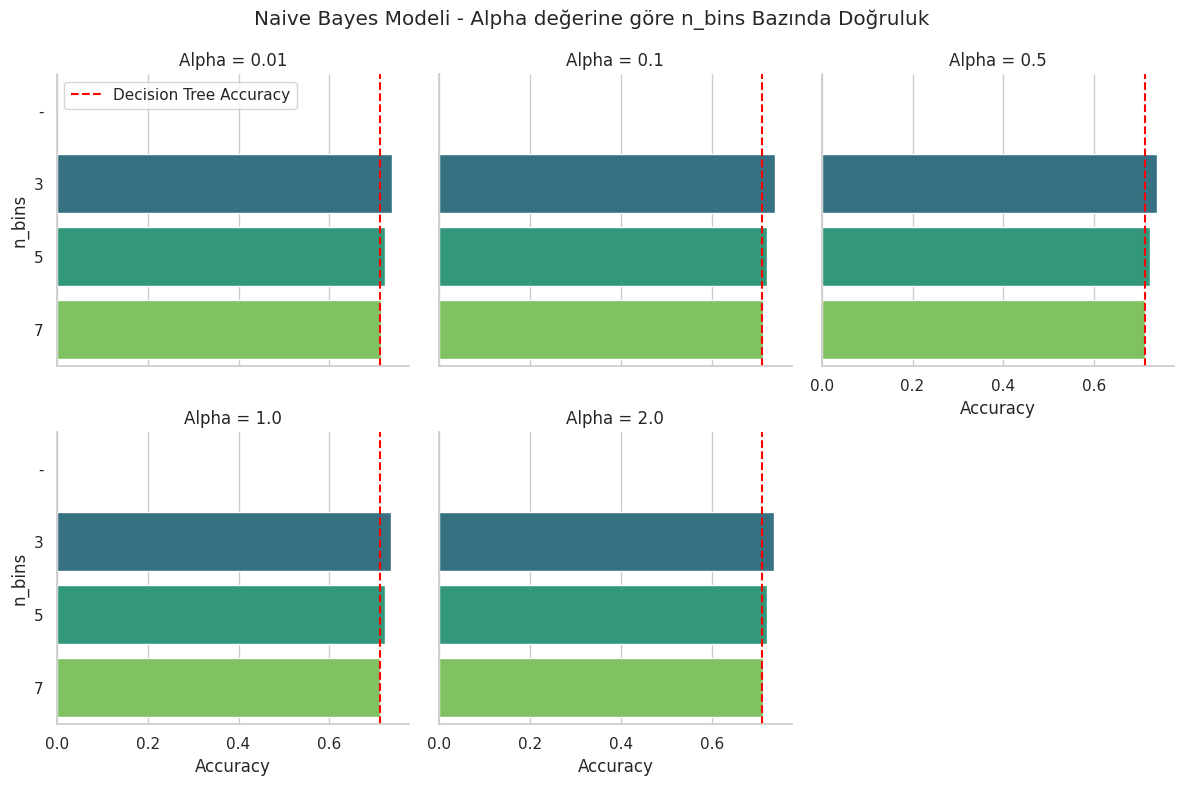

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Decision Tree için alpha ve n_bins sütunlarını dolduralım ki karşılaştırmada sorun olmasın
results_df['alpha'] = results_df['alpha'].astype(str)
results_df['n_bins'] = results_df['n_bins'].astype(str)

# Decision Tree için özel etiket verelim
results_df.loc[results_df['Model'] == 'DecisionTree', ['alpha', 'n_bins']] = ['-', '-']

# Naive Bayes sonuçları için FacetGrid ile alpha bazında grafik çizimi
g = sns.FacetGrid(results_df[results_df['Model'] == 'NaiveBayes'], col='alpha', col_wrap=3, height=4, sharex=True, sharey=True)

g.map_dataframe(sns.barplot, x='Accuracy', y='n_bins', palette='viridis', order=sorted(results_df['n_bins'].unique()))

g.set_axis_labels('Accuracy', 'n_bins')
g.set_titles(col_template='Alpha = {col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Naive Bayes Modeli - Alpha değerine göre n_bins Bazında Doğruluk')

# Aynı grafiğe Decision Tree sonuçlarını ekleyelim (tek bar olarak, her grafiğe sabit)
dt_acc = results_df.loc[results_df['Model']=='DecisionTree', 'Accuracy'].values[0]

for ax in g.axes.flat:
    ax.axvline(dt_acc, color='red', linestyle='--', label='Decision Tree Accuracy')

# Legend ayarla (sadece bir kere)
handles, labels = g.axes.flat[0].get_legend_handles_labels()
g.axes.flat[0].legend(handles, labels)

plt.show()


In [ ]:
#Naive Bayes ile Çok Sınıflı Sınıflandırma ve GridSearch ile Hiperparametre Optimizasyonu
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix

# 1. Veriyi oku
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/finalemlak2.xlsx')

# 2. Fiyatı sınıflara ayır
df['priceclass'] = pd.qcut(df['price'], q=3, labels=[0, 1, 2])

# 3. Özellik ve hedef değişkenleri ayır
y = df['priceclass']
X = df.drop(columns=['price', 'priceclass'])

# 4. Kategorik ve sayısal değişkenleri ayır
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 5. Dönüştürücüler
numerical_transformer = KBinsDiscretizer(encode='onehot-dense', strategy='uniform')  # dense olmalı
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse_output=False

# 6. Ön işlemci
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 7. Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', CategoricalNB())
])

# 8. Parametre grid'i
param_grid = {
    'preprocessor__num__n_bins': [3, 5, 7],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

# 9. Veri setini böl
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 10. GridSearch ile model eğitimi
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 11. Sonuçlar
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi CV doğruluğu:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("\nTest Seti Raporu:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


En iyi parametreler: {'clf__alpha': 0.1, 'preprocessor__num__n_bins': 3}
En iyi CV doğruluğu: 0.6827355663142641

Test Seti Raporu:
               precision    recall  f1-score   support

           0       0.69      0.81      0.75       147
           1       0.62      0.45      0.52       145
           2       0.78      0.86      0.82       144

    accuracy                           0.71       436
   macro avg       0.70      0.71      0.69       436
weighted avg       0.70      0.71      0.69       436

Confusion Matrix:
 [[119  22   6]
 [ 51  65  29]
 [  2  18 124]]


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.68273227        nan        nan 0.68273557        nan        nan
 0.67814775        nan        nan 0.67642855        nan        nan
 0.6724105         nan        nan]
  warnings.warn(
